In [80]:
from processing_functions import *
%matplotlib inline

In [81]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [82]:
# Drop build feature
# personal_data = personal_data.drop(['build'], axis=1)
# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_', 'build'], ['ovar_cancer'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of build cols: 4
['build

In [83]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


In [84]:

# Prints the table of missing values with columns for df filtered for each of the values of on_col
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=True):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    # since get_cols_missing_percentage will produce columns with the same names, we want to create suffixes to differentiate over on_col values
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    # We are going to merge all of the 
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}', show_missing=show_missing)
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0, join='outer', suffixes=['_cancer', '_no_cancer']):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    merged_df = None
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:
            df_on_col = df[df[on_col] == on_col_val]
            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=False)
        df = impute_with_val(df, df.columns, -1)
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)

## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

In [85]:
# Mean impute before converting into features
screen_data = mean_impute(screen_data, select_numeric_columns(screen_data))
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', ['study_yr'])
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')
# Mean impute after converting into features
merged_data_screen = mean_impute(merged_data_screen, select_numeric_columns(merged_data_screen))

# Drop features that are 100% missing
merged_data_screen = drop_cols_missing_percentage(100, merged_data_screen, 'merged_data_screen')

Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849
Removing features that are over 100% missing
6 columns were over 100 missing. This is the list of columns: ['tvures_qvis3__study_yr_0', 'tvures_qvis3__study_yr_1', 'tvures_qvis3__study_yr_2', 'tvures_qvis3__study_yr_4', 'tvures_qvis3__study_yr_3', 'tvures_qvis3__study_yr_5']
The table of features missing over 100 percentage: 
+--------------------------+--------------------------+---------------+---------------+-------------------+
|                          | column_name              |   num_missing |   num_present |   percent_missing |
|--------------------------+--------------------------+---------------+---------------+-------------------|
| tvures_qvis3__study_yr_0 | tvures_qvis3__study_yr_0 |         30849 |             0 |               100 |
| tvures_qvis3__study_yr_1 | tvures_qvis3__study_yr_1 |         30849 |             0 |               100 |
| tvures_qvis3__study

In [86]:
# Mean Impute before converting into new features
screen_abnorm_data = mean_impute(screen_abnorm_data, select_numeric_columns(screen_abnorm_data))
# Turn screen dataset each year into a feature
make_unique_over_cols = ['study_yr', 'side', 'source', 'VISIT', 'sbcd']
merged_data_screen_abd = merge_df_into_features(screen_abnorm_data, 'plco_id', make_unique_over_cols)
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')
# Mean Impute before converting into new features
merged_data_screen_abd = mean_impute(merged_data_screen_abd, select_numeric_columns(merged_data_screen_abd))

# Drop features that are 100% missing
merged_data_screen_abd = drop_cols_missing_percentage(100, merged_data_screen_abd, 'merged_data_screen_abd')

# Convert Categorical features
merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})

Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992
Removing features that are over 100% missing
840 columns were over 100 missing. This is the list of columns: ['side__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'sepst__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'sepst__study_yr_0_side_R_source_TVU_VISIT_3_sbcd_2', 'cyst__study_yr_0_side_R_source_TVU_VISIT_3_sbcd_2', 'sbcd__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'solid__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'source__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'solid__study_yr_0_side_R_source_TVU_VISIT_3_sbcd_2', 'study_yr__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'cystw__study_yr_0_side_R_source_TVU_VISIT_3_sbcd_2', 'VISIT__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'echo__study_yr_0_side_R_source_TVU_VISIT_3_sbcd_2', 'sepst__study_yr_3_side_R_source_TVU_VISIT_3_sbcd_1', 'cystw__study_yr_1_side_R_source_TVQ_VISIT_3_sbcd_2', 'solid__study_yr_3_side_R

## Merging Datasets

In [87]:
# Merge cancer patients dataset with screen dataset and see missing values
merge_type_cancer = 'inner'
merge_type_no_cancer = 'inner'
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_cancer)
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how=merge_type_cancer)
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_no_cancer)
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how=merge_type_no_cancer)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together.

In [88]:

# Labeled Mean Impute before converting into new features
# merged_data_cancer = mean_impute(merged_data_cancer, select_numeric_columns(merged_data_cancer))
# merged_data_no_cancer = mean_impute(merged_data_no_cancer, select_numeric_columns(merged_data_no_cancer))

In [95]:
import time
x = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)
# Mean Impute before converting into new features
x = mean_impute(x, select_numeric_columns(x))
y = x['ovar_cancer']
x = x.drop(['ovar_cancer', 'plco_id'], axis=1)
oversampling = SMOTE()
x, y = oversampling.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [97]:
# Drop profy features
proxy_features = [
    # 'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'fstcan_exitdays', # Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitstat', # Status of the participant at exit for first cancer incidence. Only cancers occuring during the trial are used to determine exit.
    ]
x = x.drop(proxy_features, axis=1)

In [91]:
# drop non-informative features
# x = x.drop(['ph_ovar_muq','orem_fyro'], axis=1)

In [92]:
# x = x.reset_index()
# y = y.reset_index()

## `TODO:` run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

## `TODO:` https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.997826  0.996382  0.997104   1382.0
1   0.996358  0.997812  0.997085   1371.0
ROC AUC score: 0.9970969355926622
Accuracy Score: 0.9970940791863422


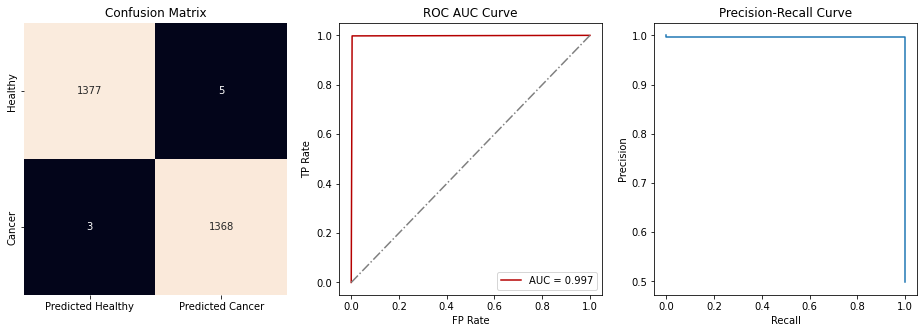

['ph_ovar_sqx']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.996387  0.997829  0.997108   1382.0
1   0.997809  0.996353  0.997080   1371.0
ROC AUC score: 0.9970911299916294
Accuracy Score: 0.9970940791863422


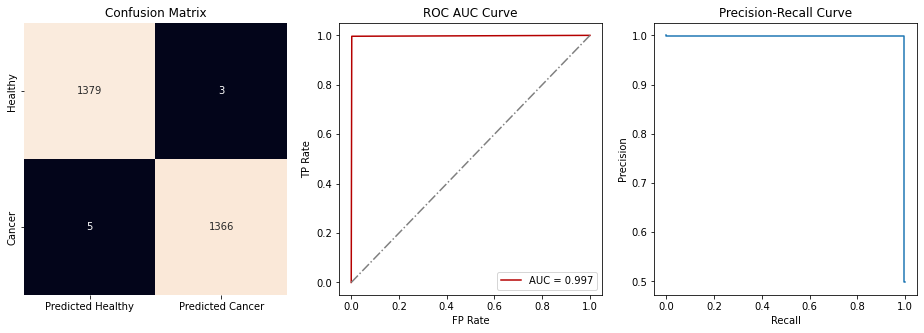

['f_codeath_cat']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.995643  0.992041  0.993838   1382.0
1   0.992006  0.995624  0.993811   1371.0
ROC AUC score: 0.9938320766846007
Accuracy Score: 0.9938249182709771


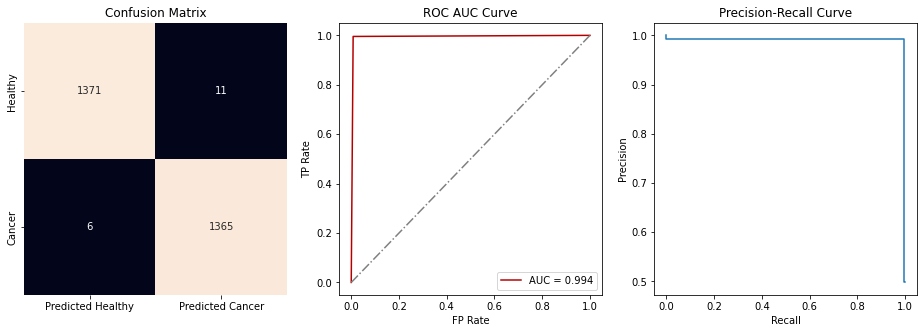

['ph_ovar_dhq']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.995646  0.992764  0.994203   1382.0
1   0.992727  0.995624  0.994173   1371.0
ROC AUC score: 0.9941938711853243
Accuracy Score: 0.9941881583726844


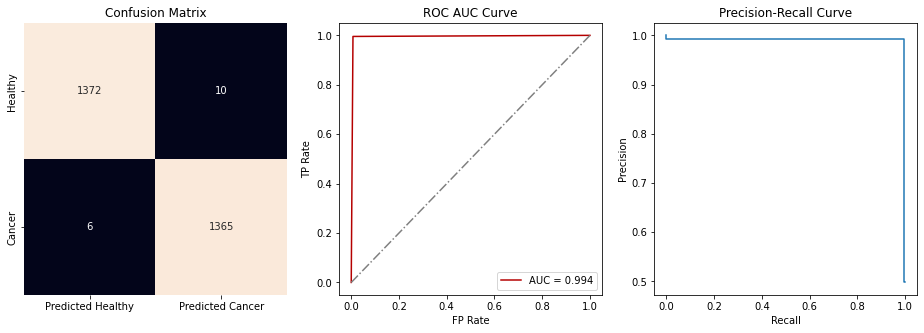

['d_codeath_cat']
DecisionTreeClassifier
   precision    recall  f1-score  support
0    0.99563  0.989146  0.992377   1382.0
1    0.98913  0.995624  0.992366   1371.0
ROC AUC score: 0.9923848986817064
Accuracy Score: 0.9923719578641482


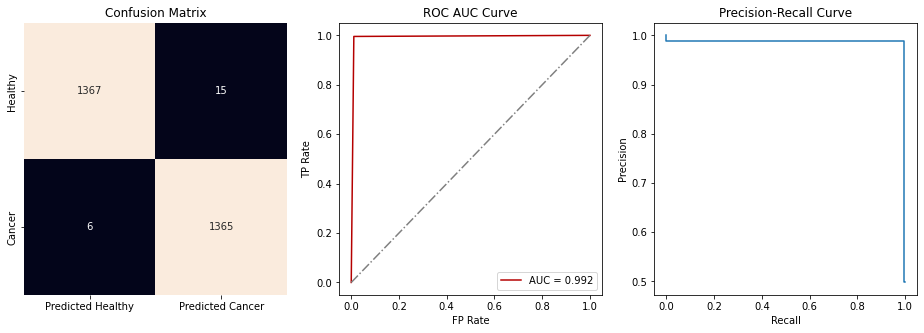

['f_cancersite']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.995640  0.991317  0.993474   1382.0
1   0.991285  0.995624  0.993450   1371.0
ROC AUC score: 0.9934702821838771
Accuracy Score: 0.9934616781692699


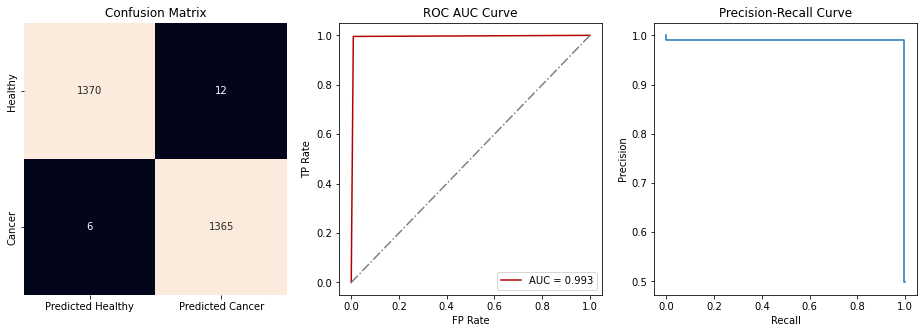

['f_dthovar']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.995636  0.990593  0.993108   1382.0
1   0.990566  0.995624  0.993088   1371.0
ROC AUC score: 0.9931084876831535
Accuracy Score: 0.9930984380675627


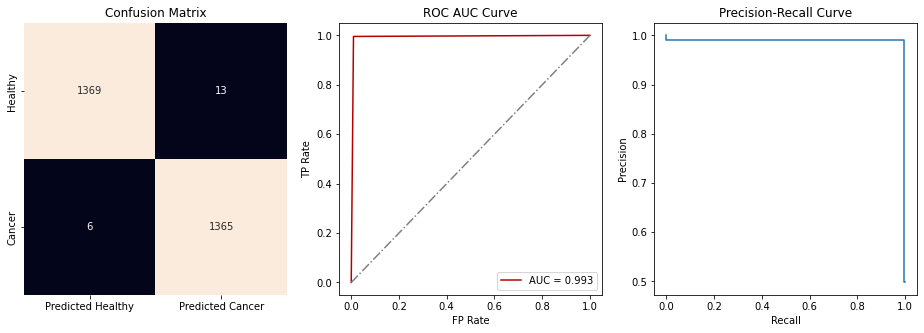

['f_seer_death']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.994913  0.990593  0.992748   1382.0
1   0.990559  0.994894  0.992722   1371.0
ROC AUC score: 0.9927437903819136
Accuracy Score: 0.9927351979658554


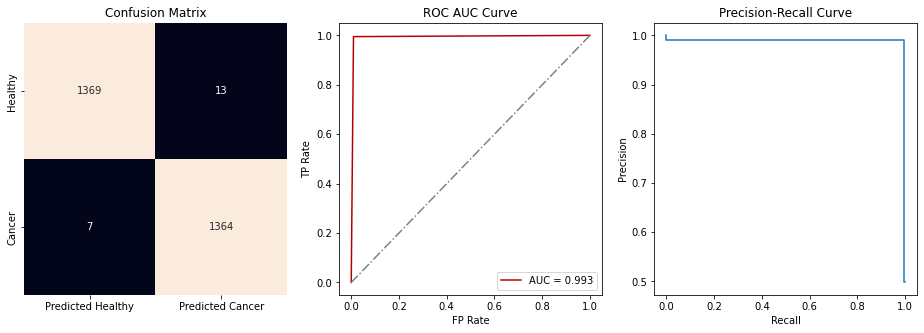

['ph_ovar_muq']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.994909  0.989870  0.992383   1382.0
1   0.989840  0.994894  0.992361   1371.0
ROC AUC score: 0.99238199588119
Accuracy Score: 0.9923719578641482


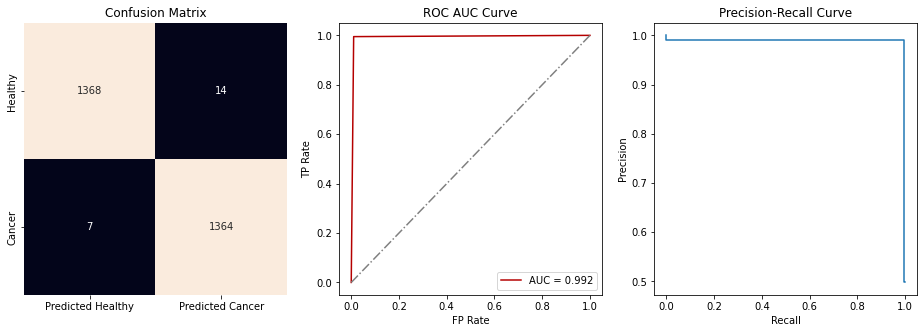

['d_seer_death']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.993464  0.989870  0.991664   1382.0
1   0.989826  0.993435  0.991627   1371.0
ROC AUC score: 0.9916526012787101
Accuracy Score: 0.9916454776607337


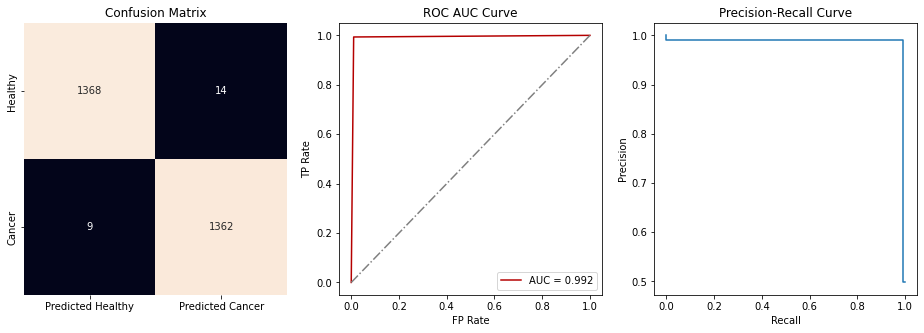

['d_cancersite']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.992754  0.991317  0.992035   1382.0
1   0.991260  0.992706  0.991983   1371.0
ROC AUC score: 0.9920114929789171
Accuracy Score: 0.9920087177624409


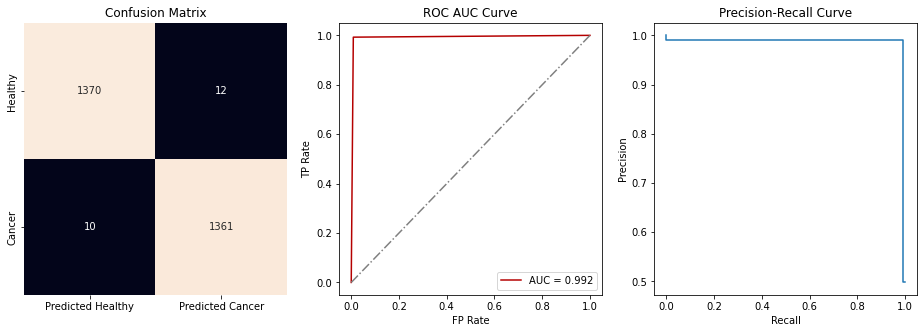

['d_dthovar']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.991906  0.975398  0.983583   1382.0
1   0.975610  0.991977  0.983725   1371.0
ROC AUC score: 0.9836873166617583
Accuracy Score: 0.9836541954231747


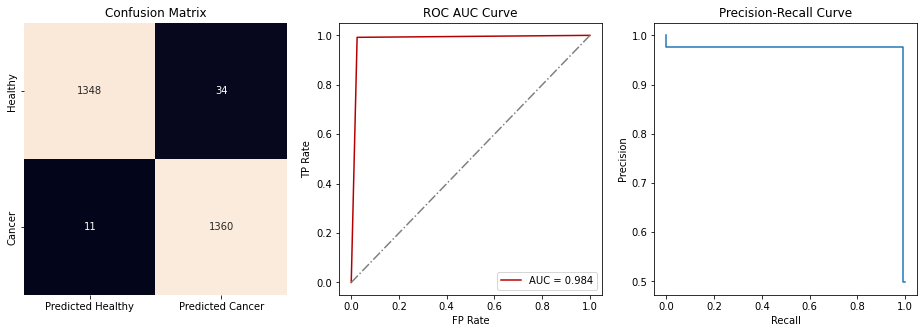

['ph_any_sqx']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.990476  0.978292  0.984347   1382.0
1   0.978386  0.990518  0.984415   1371.0
ROC AUC score: 0.9844051000621726
Accuracy Score: 0.9843806756265892


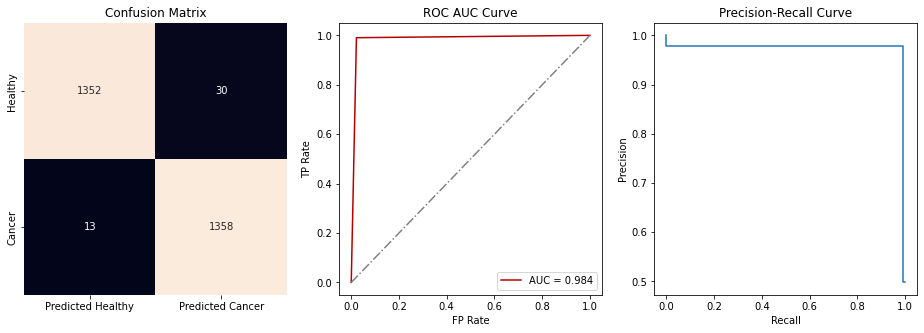

['ph_any_muq']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.990504  0.981187  0.985823   1382.0
1   0.981214  0.990518  0.985844   1371.0
ROC AUC score: 0.985852278065067
Accuracy Score: 0.9858336360334181


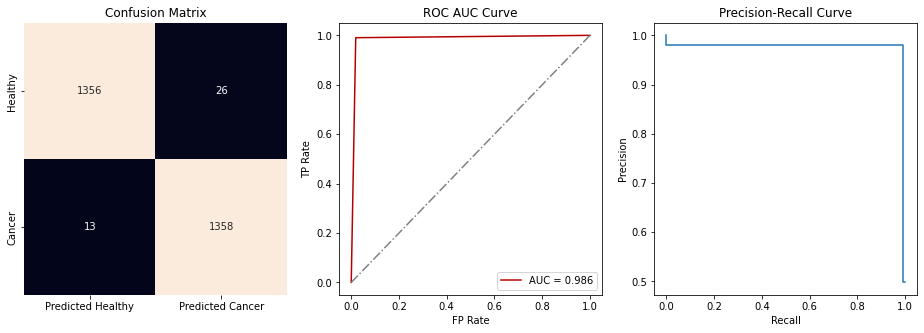

['ovar_result__study_yr_5']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.991228  0.981187  0.986182   1382.0
1   0.981227  0.991247  0.986212   1371.0
ROC AUC score: 0.986216975366307
Accuracy Score: 0.9861968761351253


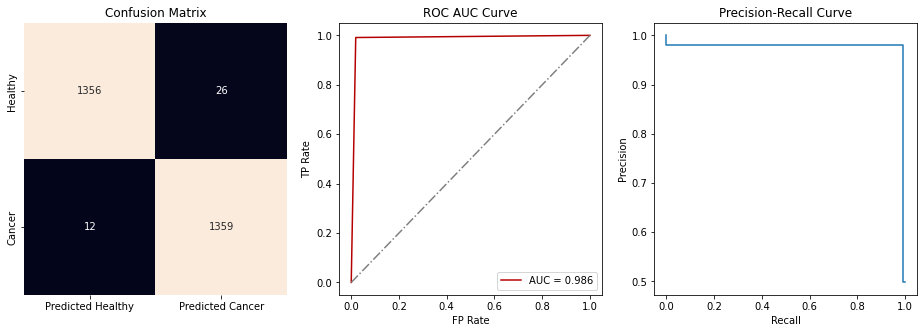

['ca125_result__study_yr_5']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.991254  0.984081  0.987654   1382.0
1   0.984070  0.991247  0.987645   1371.0
ROC AUC score: 0.9876641533692014
Accuracy Score: 0.9876498365419543


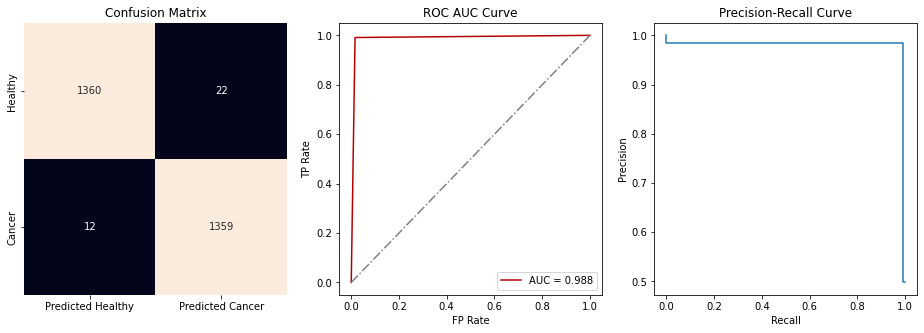

['ca125_result5']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.988304  0.978292  0.983273   1382.0
1   0.978339  0.988330  0.983309   1371.0
ROC AUC score: 0.9833110081584527
Accuracy Score: 0.9832909553214675


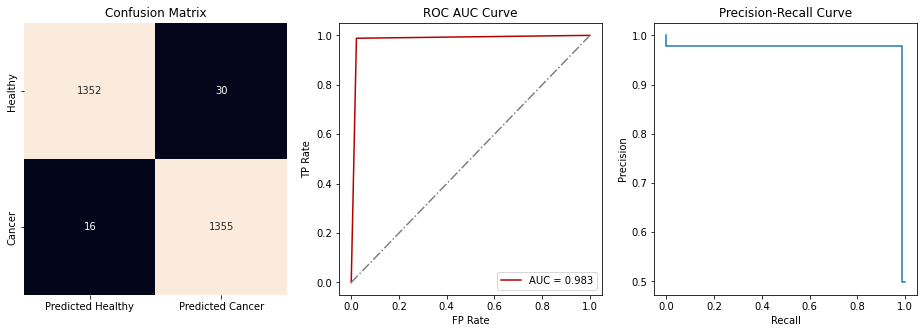

['ph_any_dhq']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.986121  0.976845  0.981461   1382.0
1   0.976879  0.986142  0.981488   1371.0
ROC AUC score: 0.9814933272532855
Accuracy Score: 0.9814747548129313


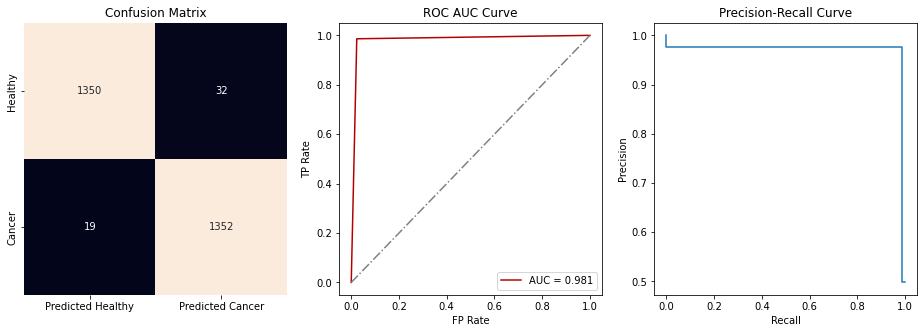

['ca125_src__study_yr_5']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.987618  0.981187  0.984392   1382.0
1   0.981159  0.987600  0.984369   1371.0
ROC AUC score: 0.9843934888601072
Accuracy Score: 0.9843806756265892


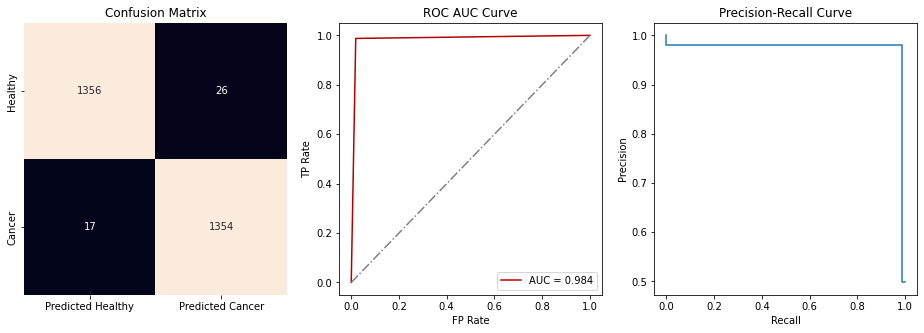

['ca125ii_src__study_yr_5']
DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.986880  0.979740  0.983297   1382.0
1   0.979725  0.986871  0.983285   1371.0
ROC AUC score: 0.98330520255742
Accuracy Score: 0.9832909553214675


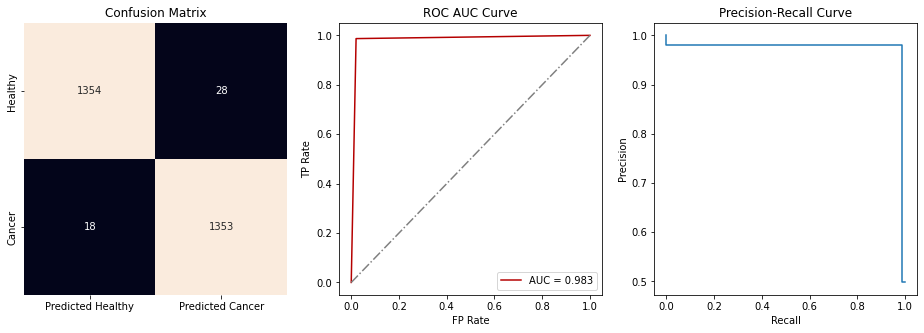

['fstcan_exitage']


KeyError: 'importance'

In [100]:
from sklearn.linear_model import LogisticRegression, LinearRegression
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
trial_x = x
plot_tree = False
df_feature_importance_tree = None
df_top_feature_importances = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(trial_x, y, test_size = 0.2, random_state = 42)
    auc_dict = {}
    accuracy_dict = {}
    top_feature_importance = []
    for classifier_type, classifier in classifiers.items():
        print(classifier_type)
        auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)
        if classifier_type == 'DecisionTreeClassifier':
            fn=X_train.columns
            if plot_tree:
                cn=['no cancer', 'cancer']
                fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
                tree.plot_tree(classifier,
                    feature_names = fn, 
                    class_names=cn,
                    filled = True)
                plt.show()
            feature_importances = pd.DataFrame(classifier.feature_importances_,
                                index = fn,
                                columns=['importance']).sort_values('importance', 
                                                                    ascending=False)
            feature_importances['feature'] = feature_importances.index
            feature_importances = feature_importances[['feature', 'importance']]
            top_feature_importance.append(feature_importances.iloc[0]['feature'])
            y_pred = classifier.predict(X_test)
            y_prob = classifier.predict_proba(X_test)[:,1]
            # TODO: boundary and confusion matrix
            df_top_feature_importances.append({
                'top_feature': feature_importances.iloc[0]['feature'],
                'boundary': 0,
                'importance': round(feature_importances.iloc[0]['importance'], 3),
                'tree_depth': classifier.tree_.max_depth,
                'accuracy': accuracy,
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1-score': f1_score(y_test, y_pred),
            })
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='feature', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
            else:
                df_feature_importance_tree = feature_importances
            # print_df(feature_importances)
        auc_dict[classifier_type] = auc
        accuracy_dict[classifier_type] = accuracy
    trial_x = trial_x.drop(top_feature_importance, axis=1)
    print(top_feature_importance)

# df_feature_importance_tree = df_feature_importance_tree[df_feature_importance_tree['importance'] > 0]
# print_df(df_feature_importance_tree)
print_df(pd.DataFrame(df_top_feature_importances))

In [101]:
print_df(pd.DataFrame(df_top_feature_importances))

+----+--------------------------+------------+--------------+--------------+------------+-------------+----------+------------+
|    | top_feature              |   boundary |   importance |   tree_depth |   accuracy |   precision |   recall |   f1-score |
|----+--------------------------+------------+--------------+--------------+------------+-------------+----------+------------|
|  0 | ph_ovar_sqx              |          0 |        0.431 |           10 |   0.997094 |    0.996358 | 0.997812 |   0.997085 |
|  1 | f_codeath_cat            |          0 |        0.404 |           12 |   0.997094 |    0.997809 | 0.996353 |   0.99708  |
|  2 | ph_ovar_dhq              |          0 |        0.334 |           12 |   0.993825 |    0.992006 | 0.995624 |   0.993811 |
|  3 | d_codeath_cat            |          0 |        0.332 |           12 |   0.994188 |    0.992727 | 0.995624 |   0.994173 |
|  4 | f_cancersite             |          0 |        0.377 |           13 |   0.992372 |    0.98913  | 

In [ ]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
# f_score(X_train, X_test, y_train, y_test, classifiers)

In [ ]:
def select_using_model():
    sel = SelectFromModel(XGBClassifier())
    sel.fit(x,y)

In [ ]:
def select_using_score_func():
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # what are scores for the features
    features_scores = pd.DataFrame(x.columns)
    features_scores['scores'] = fs.scores_
    features_scores = features_scores.sort_values('scores', ascending=False)
    features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

In [ ]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.